In [110]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import papermill as pm
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [554]:
#EDITABLE PARAMETERS 

# Project root (parent of Examples if needed)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "examples":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Capacities from CEM results
cem_results = pd.read_csv(PROJECT_ROOT / "data" / "CEM_results" / "cem_results.csv")
def cap(resource):  # sums if multiple rows exist
    return int(cem_results.loc[cem_results['resource'] == resource, 'CAP'].sum())

Wind_Cap    = cap('onshore_wind_turbine')
Solar_Cap   = cap('solar_photovoltaic')
Nuclear_Cap = cap('ap1000')
PHS_Cap     = cap('hydroelectric_pumped_storage')

# --- DO NOT CHANGE ---
horizon         = 72
load_percentage = 1.0
PHS_percentage  = 0.1
model_name      = 'ap1000'
VRE_percentage  = 0.2
mAP300          = 0.001137
mAP100          = 0.001137
q               = 0.11
nuclear_unit    = 0

# --- CONFIGURABLE [CHANGE FOR DIFFERENT SCENARIOS] ---
pmin           = 1         #minimum generation percentages for nuclear reactors 
PHS_duration   = 4            #battery duration
cost_frac      = 1.0          #fraction of startup/shutdown cost for nuclear. 1 means 100%
k_init_ap1000  = 1.205        #initial k_eff value
mAP1000        = 0.001137     #degradation rate
start_day      = 0            #dispatch init period [3 day blocks]
end_day        = 360            #dispatch end period  [3 day blocks]
refuel_span    = 10           #span of refueling outage

# Change Filename if desired. Both 
config_name = f"mode1_pmin{pmin}_PHSduration{PHS_duration}_\
costfrac{cost_frac}_kinit{k_init_ap1000}_startday{start_day}_endday{end_day}_refuelspan{refuel_span}.txt"

In [555]:
# [DONT EDIT] Save the current parameters to Config/<config_name> as Python assignments 
def _to_builtin(v):
    if isinstance(v, (np.integer,)):  return int(v)
    if isinstance(v, (np.floating,)): return float(v)
    if isinstance(v, (np.bool_,))  :  return bool(v)
    return v

def save_config_txt(cfg_path: Path, scope: dict):
    lines = []
    keys = [
        # capacities
        "Wind_Cap","Solar_Cap","Nuclear_Cap","PHS_Cap",
        # fixed
        "horizon","load_percentage","PHS_percentage","model_name","VRE_percentage",
        "mAP300","mAP100","q","nuclear_unit",
        # configurable
        "pmin","PHS_duration","cost_frac","k_init_ap1000","mAP1000",
        "start_day","end_day","refuel_span",
    ]
    for k in keys:
        v = _to_builtin(scope[k])
        if isinstance(v, str):
            lines.append(f'{k} = "{v}"')
        else:
            lines.append(f"{k} = {v}")
    cfg_path.write_text("\n".join(lines) + "\n", encoding="utf-8")
    return cfg_path

CONFIG_DIR = PROJECT_ROOT / "Config"
CONFIG_DIR.mkdir(parents=True, exist_ok=True)
cfg_path = save_config_txt(CONFIG_DIR / config_name, globals())
print("Wrote:", cfg_path)

Wrote: /Users/shinychoudhury/Library/CloudStorage/Dropbox/TYNAN_Lab/Research/5_NuclearReactor_technical/physics-informed-nuclear-fleet-unit-commitment/Config/mode1_pmin1_PHSduration4_costfrac1.0_kinit1.205_startday0_endday360_refuelspan10.txt


In [556]:
#Solve various notebooks and save results for the configrations in config_name

subfolder_name = Path(config_name).stem

# Make sure subfolder exists
out_dir = PROJECT_ROOT / "results" / subfolder_name
out_dir.mkdir(parents=True, exist_ok=True)

print("Running...")

pm.execute_notebook(
    str(PROJECT_ROOT / "master_UC_nuclear.ipynb"),
    str(out_dir / "output_master_run.ipynb"),   # output notebook in subfolder
    parameters={
        "file_path": str(cfg_path),  # pass config file
        "subfolder_name": str(out_dir)                 # also pass path inside notebook
    },
    cwd=str(PROJECT_ROOT),
    log_output=False,
    progress_bar=False,
)

print("Finished.")

Running...
Finished.


In [551]:
#Collate results and sumamrize statistics
result_path=os.getcwd() + '/results/' + Path(config_name).stem
master_df=pd.read_csv(result_path + '/aggregate_results.csv')
master_shut_df=pd.read_csv(result_path + '/shut_count_and_obj_value.csv')
master_kinfTable=pd.read_csv(result_path + '/master_kinfTable.csv')
master_commit=pd.read_csv(result_path + '/commit_results.csv')

#columns of interest
temp=master_df[[model_name,"solar_photovoltaic","onshore_wind_turbine","NSE", "discharge", "charge", "demand"]]
temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]

#sum of hourly demand
demand_sum=temp.demand.sum()

#columns for tabulation
cols = [model_name, "VRE", "discharge", "NSE"]
temp = temp.loc[:, cols].copy() 

#compute statistics for each source
genresulttable=pd.DataFrame()
genresulttable['gen_mwh']= temp.sum().astype(int)                            #in MwH
genresulttable['gen_mwh_%']= (100 * temp.sum() / (demand_sum)).astype(int)   #% of demand

print("Generation percentage by resource: \n", tabulate(genresulttable.reset_index(), headers='keys', tablefmt='fancy_grid'))


#Net VRE curtailment
total_curtail = master_df["curtail"].sum()
pct_curtail = total_curtail / master_df["max_vre_possible"].sum() * 100
vre_pct   = sum(master_df['curtail'])       / sum(master_df['max_vre_possible']) * 100
solar_pct = sum(master_df['solar_curtail']) / sum(master_df['max_vre_possible']) * 100
wind_pct  = sum(master_df['wind_curtail'])  / sum(master_df['max_vre_possible']) * 100

print(f"VRE curtailment (MWh): {total_curtail:.2f} | % of net VRE: {pct_curtail:.2f}%")
print(f"% of solar curtailed: {solar_pct:.2f}%")
print(f"% of wind curtailed:  {wind_pct:.2f}%")

#Net production Cost
net_cost = sum(master_shut_df['obj_value']) - (master_df['NSE'].sum() * 9000)

print("Net production cost with NSE penalty:\n", format(net_cost, ".2e"))

#Total startups and shutdowns by fleet
print(f"Net shutdowns: {master_shut_df['shut_count'].sum()} | Net startups: {master_shut_df['start_count'].sum()}")

master_commit = master_commit.loc[:, ~master_commit.columns.str.contains('Unnamed')]

master_commit["sum_commit"] = master_commit.drop(columns="hour", errors="ignore").apply(pd.to_numeric, errors="coerce").sum(axis=1)*1000

Generation percentage by resource: 
 ╒════╤═══════════╤═══════════╤═════════════╕
│    │ index     │   gen_mwh │   gen_mwh_% │
╞════╪═══════════╪═══════════╪═════════════╡
│  0 │ ap1000    │  71560430 │          35 │
├────┼───────────┼───────────┼─────────────┤
│  1 │ VRE       │ 111787536 │          54 │
├────┼───────────┼───────────┼─────────────┤
│  2 │ discharge │  15080774 │           7 │
├────┼───────────┼───────────┼─────────────┤
│  3 │ NSE       │   5705720 │           2 │
╘════╧═══════════╧═══════════╧═════════════╛
VRE curtailment (MWh): 8175556.00 | % of net VRE: 5.79%
% of solar curtailed: 2.68%
% of wind curtailed:  3.11%
Net production cost with NSE penalty:
 7.48e+08
Net shutdowns: 224 | Net startups: 229


<ipython-input-551-351dbc2ae1c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]


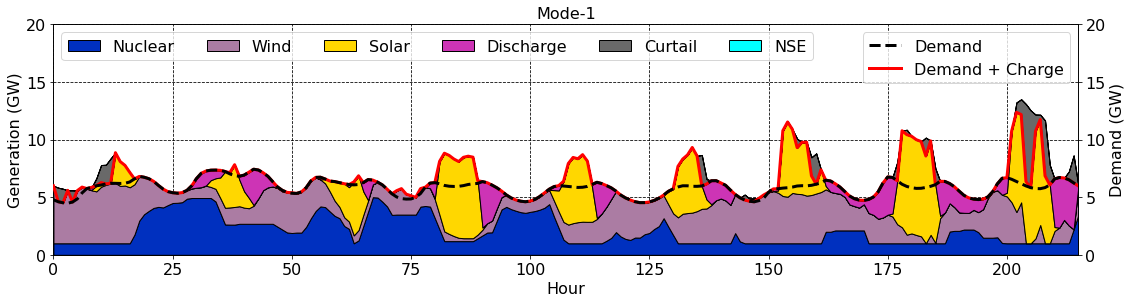

In [542]:


# start = 6
# end = start+2
# temp = master_df[(master_df['n'] >= start) & (master_df['n'] <= end)].reset_index()

# Create relative hour axis (starts from 0)
temp['Hour_rel'] = temp['Hour'] - temp['Hour'].iloc[0]

# plottable = temp[[model_name, 'actual_wind', 'actual_solar', 'charge', 'discharge', 'curtail', 'NSE', 'demand']]
plottable = temp[[model_name, 'solar_photovoltaic', 'onshore_wind_turbine', 'charge', 'discharge', 'curtail', 'NSE', 'demand']]


# Plot setup
# fig, ax1 = plt.subplots(figsize=(8, 6))
fig, ax1 = plt.subplots(figsize=(16, 4.5))

#Labels for stackplot (excluding charge)
# labels = [model_name, 'actual_wind', 'actual_solar', 'discharge', 'curtail', 'NSE']
labels = [model_name, 'onshore_wind_turbine', 'solar_photovoltaic', 'discharge', 'curtail', 'NSE']
labelnames = ['Nuclear', 'Wind', 'Solar', 'Discharge', 'Curtail', 'NSE']

# Color assignment with curtail as red 
if model_name == 'ap1000':
    # base_colors = ['navy', 'limegreen', 'gold', 'violet', 'dimgray', 'cyan']
    base_colors = ['#0030bf', '#ab7ca3', '#ffd700', '#cd34b5', 'dimgray', 'cyan']
else:
    base_colors = ['#542788', '#feb24c', '#41ab5d', 'yellow', 'red', 'cyan']

# === Grid behind everything ===
ax1.grid(True, linestyle='--', color='black', zorder=0)

#Stackplot (excluding charge) 
data = [plottable[label].values for label in labels]
ax1.stackplot(temp['Hour_rel'].values, *data, colors=base_colors, labels=labelnames, edgecolor='black', zorder=2)

# Axis labels and limits
ax1.set_xlabel('Hour')
ax1.set_ylabel('Generation (GW)')
ax1.set_ylim([0, 20.0e3])
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.tick_params(axis='y', labelcolor='black')

# Secondary axis: Demand
ax2 = ax1.twinx()
ax2.plot(temp['Hour_rel'].values, plottable['demand'].values, color='black', label='Demand', linewidth=3, linestyle='--',zorder=4)

ax2.plot(
    temp['Hour_rel'].values,
    plottable['demand'].values + plottable['charge'].values,
    color='red',
    label='Demand + Charge',
    zorder=3,
    linewidth=3
)


ax2.set_ylim([0, 20.0e3])
ax2.set_ylabel('Demand (GW)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax2.tick_params(axis='y', labelcolor='black')

# X-limits: Reset from 0 to duration
ax1.set_xlim(0, temp['Hour_rel'].max())

# === Title and layout ===
plt.title('Mode-1', fontsize=16)
plt.tight_layout()
ax1.legend(loc='upper left', ncol=7)
ax2.legend(loc='best')

# plt.savefig('mode1_long.png')

#  Show 
plt.show()